In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

In [2]:
# Load the dataset
df = pd.read_csv("BETTER30.csv")
print("Dataset Information:")
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CONVERSATION_ID    650 non-null    int64 
 1   CONVERSATION_STEP  650 non-null    int64 
 2   TEXT               650 non-null    object
 3   CONTEXT            646 non-null    object
 4   LABEL              649 non-null    object
 5   FEATURES           573 non-null    object
 6   ANNOTATIONS        248 non-null    object
dtypes: int64(2), object(5)
memory usage: 35.7+ KB


In [3]:
df.describe

<bound method NDFrame.describe of      CONVERSATION_ID  CONVERSATION_STEP  \
0                  6                  1   
1                  6                  2   
2                  6                  3   
3                  6                  4   
4                  6                  5   
..               ...                ...   
645               68                  5   
646               68                  6   
647               68                  7   
648               68                  8   
649               68                  9   

                                                  TEXT  \
0    Good morning, this is [Your Name]'s personal a...   
1    Hello, my name is Jamie. I'm interested in vol...   
2    Yes, I'm really passionate about environmental...   
3    Great, how do I sign up, and where can I find ...   
4    Could you send me the link, please? And my ema...   
..                                                 ...   
645  Would it be possible to receive some l

**Handling Mislocated Text**

In [4]:
# Handling mislocated LABEL in ANNOTATIONS
df['ANNOTATIONS'] = df['ANNOTATIONS'].fillna('')  # Replace null with empty string

for index, row in df.iterrows():
    if row['ANNOTATIONS'].startswith(' '):
        if row['ANNOTATIONS'].startswith(' "'):
            continue
        else:
            df.at[index, 'FEATURES'] = row['FEATURES'].strip() + ', ' + row['ANNOTATIONS'].strip()
            df.at[index, 'ANNOTATIONS'] = ''

In [5]:
# Handling mislocated text at CONTEXT
for index, row in df.iloc[166:197].iterrows():
    if row['CONVERSATION_STEP'] != 1 and pd.notnull(row['CONTEXT']):
        step_text = f" [Step: {row['CONVERSATION_STEP'] - 1}] "
        df.at[index, 'TEXT'] = row['TEXT'].strip() + step_text + row['CONTEXT'].strip()
        df.at[index, 'CONTEXT'] = None
    else:
        continue

**Clean Text**

In [6]:
def clean_text1(text):
    if pd.notnull(text):
        text = text.lower()
        text = text.lstrip()
        text = text.rstrip()
        text = text.replace('"', '')

    return text

def clean_text2(text):
    if pd.notnull(text):
        text = text.lstrip()
        text = text.rstrip()
        text = text.replace('"', '')

    return text

df["CONTEXT"] = df["CONTEXT"].apply(clean_text2)
df["LABEL"] = df["LABEL"].apply(clean_text1)
df["FEATURES"] = df["FEATURES"].apply(clean_text1)
df["ANNOTATIONS"] = df["ANNOTATIONS"].apply(clean_text2)

**Drop duplicate rows**

In [7]:
df = df.drop_duplicates()

**Removing Response Text**

In [8]:
# Remove response after '[Step: ]' and before '[context]'
def remove_response(text):
    if pd.notnull(text) and '[Step:' in text:
        return text.split('[Step:')[0].strip()
    
    elif '[Your Name]' in text:
        return text
        
    elif ']' in text:
        return text.split(']')[1].strip()
    
    return text
df['TEXT'] = df['TEXT'].apply(remove_response)

# Remove response for conversation id 32-68
df = df[~((df['CONVERSATION_ID'].between(32, 68)) & (df['CONVERSATION_STEP'] % 2 != 0))]

# Remove rows where CONVERSATION_STEP == 1
df = df[df['CONVERSATION_STEP'] != 1]

# Conversation id 31 (remove step 5 and 8)
df = df.drop(df[(df['CONVERSATION_ID'] == 31) & (df['CONVERSATION_STEP'].isin([5, 8]))].index).reset_index(drop=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_19964\4054962886.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TEXT'] = df['TEXT'].apply(remove_response)


**Generate Missing Context** or **Fill unknown**

In [ ]:
# Fill missing values in CONTEXT with 'unknown' or other strategy
#df['CONTEXT'] = df['CONTEXT'].fillna('unknown')
df['FEATURES'] = df['FEATURES'].fillna('unknown')

In [ ]:
# Load the dataset
df = pd.read_csv("conversation.csv")

# Preprocessing: Fill NAs temporarily for train-test split
df['CONTEXT'] = df['CONTEXT'].fillna("")

# Split into training and testing
train_data = df[df['CONTEXT'] != ""]
test_data = df[df['CONTEXT'] == ""]

# Tokenizer and Dataset preparation
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Map context labels to integers
label_map = {label: idx for idx, label in enumerate(train_data['CONTEXT'].unique())}
train_data['CONTEXT_LABEL'] = train_data['CONTEXT'].map(label_map)

# Tokenize training data
train_texts = train_data['TEXT'].tolist()
train_labels = train_data['CONTEXT_LABEL'].tolist()

train_encodings = tokenizer(train_texts, padding="max_length", truncation=True, max_length=128, return_tensors="tf")
train_labels = tf.convert_to_tensor(train_labels)

# Prepare TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    {key: train_encodings[key] for key in ['input_ids', 'attention_mask']},
    train_labels
)).shuffle(len(train_texts)).batch(16)

# Load the TensorFlow model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_map))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train the model
model.fit(train_dataset, epochs = 20)

# Predict missing contexts
test_texts = test_data['TEXT'].tolist()
test_encodings = tokenizer(test_texts, padding="max_length", truncation=True, max_length=128, return_tensors="tf")

# Perform predictions
predictions = model.predict({key: test_encodings[key] for key in ['input_ids', 'attention_mask']})
predicted_labels = tf.argmax(predictions.logits, axis=1).numpy()

# Map predicted labels back to contexts
reverse_label_map = {v: k for k, v in label_map.items()}
test_data['CONTEXT'] = [reverse_label_map[label] for label in predicted_labels]

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\USER\AppData\Local\Temp\ipykernel_19964\700269890.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['CONTEXT_LABEL'] = train_data['CONTEXT'].map(label_map)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20


21/21 [==============================] - 256s 10s/step - loss: 5.8301 - accuracy: 0.0061
Epoch 2/20
21/21 [==============================] - 173s 8s/step - loss: 5.7225 - accuracy: 0.0061
Epoch 3/20
21/21 [==============================] - 178s 8s/step - loss: 5.6083 - accuracy: 0.0092
Epoch 4/20
21/21 [==============================] - 191s 9s/step - loss: 5.5186 - accuracy: 0.0183
Epoch 5/20
21/21 [==============================] - 181s 9s/step - loss: 5.4255 - accuracy: 0.0214
Epoch 6/20
21/21 [==============================] - 188s 9s/step - loss: 5.3049 - accuracy: 0.0612
Epoch 7/20
21/21 [==============================] - 195s 9s/step - loss: 5.2220 - accuracy: 0.0673
Epoch 8/20
21/21 [==============================] - 191s 9s/step - loss: 5.1287 - accuracy: 0.1284
Epoch 9/20
21/21 [==============================] - 177s 8s/step - loss: 5.0183 - accuracy: 0.2110
Epoch 10/20
21/21 [==============================] - 184s 9s/step - loss: 4.9152 - accuracy: 0.2446
Epoch 

C:\Users\USER\AppData\Local\Temp\ipykernel_19964\700269890.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['CONTEXT'] = [reverse_label_map[label] for label in predicted_labels]


**Label Encoding**

In [10]:
# Check the unique values in the 'LABEL' column
print("Unique values in LABEL column:", df['LABEL'].unique())

# Check the distribution of the target variable (fraud vs non-fraud)
print("\nDistribution of 'LABEL' column:")
print(df['LABEL'].value_counts())

Unique values in LABEL column: ['neutral' 'suspicious' 'highly_suspicious' 'slightly_suspicious'
 'legitimate' 'scam' 'potential_scam']

Distribution of 'LABEL' column:
LABEL
scam                   189
neutral                 98
legitimate              29
suspicious              26
potential_scam           7
slightly_suspicious      6
highly_suspicious        3
Name: count, dtype: int64


In [45]:
# Define scam-related and non-scam-related labels
scam_labels = [
    'scam', 'suspicious', 'highly_suspicious', 'slightly_suspicious', 'potential_scam',
]
non_scam_labels = [
    'neutral', 'legitimate'
]

# Function to classify labels as 'scam' or 'non-scam'
def classify_label(label):
    if label in scam_labels:
        return 'scam'
    elif label in non_scam_labels:
        return 'non-scam'
    else:
        return 'unknown'  # For any labels not categorized

# Apply the classification function to the 'LABEL' column
df['CATEGORY'] = df['LABEL'].apply(classify_label)

# Prepare features (X) and target (y)
X = df['LABEL']  # Replace with 'TEXT' if that's the actual column name for text data
y = df['CATEGORY']

# Encode labels (scam -> 1, non-scam -> 0, unknown -> 2)
label_encoder = LabelEncoder()
df['CATEGORY'] = label_encoder.fit_transform(y)

# Display the updated DataFrame
print(df)

     CONVERSATION_ID  CONVERSATION_STEP  \
0                  6                  2   
1                  6                  3   
2                  6                  4   
3                  6                  5   
4                  6                  6   
..               ...                ...   
158               28                  7   
159               28                  8   
160               27                  2   
161               27                  3   
251               51                 10   

                                                  TEXT  \
0    Hello, my name is Jamie. I'm interested in vol...   
1    Yes, I'm really passionate about environmental...   
2    Great, how do I sign up, and where can I find ...   
3    Could you send me the link, please? And my ema...   
4    Thank you so much for your help. I'm really lo...   
..                                                 ...   
158  You're making a big mistake by delaying. Your ...   
159  You'll regret 

**Update Dataset**

In [36]:
df.describe
df.info()
print(df.isnull().any())

<class 'pandas.core.frame.DataFrame'>
Index: 358 entries, 0 to 251
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CONVERSATION_ID    358 non-null    int64 
 1   CONVERSATION_STEP  358 non-null    int64 
 2   TEXT               358 non-null    object
 3   CONTEXT            358 non-null    object
 4   LABEL              358 non-null    object
 5   FEATURES           358 non-null    object
 6   CATEGORY           358 non-null    object
dtypes: int64(2), object(5)
memory usage: 22.4+ KB
CONVERSATION_ID      False
CONVERSATION_STEP    False
TEXT                 False
CONTEXT              False
LABEL                False
FEATURES             False
CATEGORY             False
dtype: bool


In [ ]:
df = pd.concat([train_data, test_data]) # Fill generated context
df['CATEGORY'] = label_encoder.fit_transform(y) # Categorize Label
df = df.drop(columns='ANNOTATIONS')
df = df.drop(columns='CONTEXT_LABEL')   # Drop unnecessary columns
df['FEATURES'] = df['FEATURES'].fillna('unknown')   # Fill null
df.to_csv("call_transcript_cleaned.csv", index=False)

print("Dataset is updated!")

Dataset is updated!


In [48]:
df = pd.read_csv('conversation.csv')

print(df.shape)
print(df.describe(exclude='number'))

(358, 8)
                                                     TEXT  \
count                                                 358   
unique                                                349   
top     You're making this more difficult than it need...   
freq                                                    3   

                                                  CONTEXT LABEL  \
count                                                 358   358   
unique                                                321     7   
top     Scammer pressures for immediate financial acti...  scam   
freq                                                    5   189   

                    FEATURES  
count                    337  
unique                   290  
top     verification_request  
freq                      17  


C:\Users\USER\AppData\Local\Temp\ipykernel_19964\1200325423.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


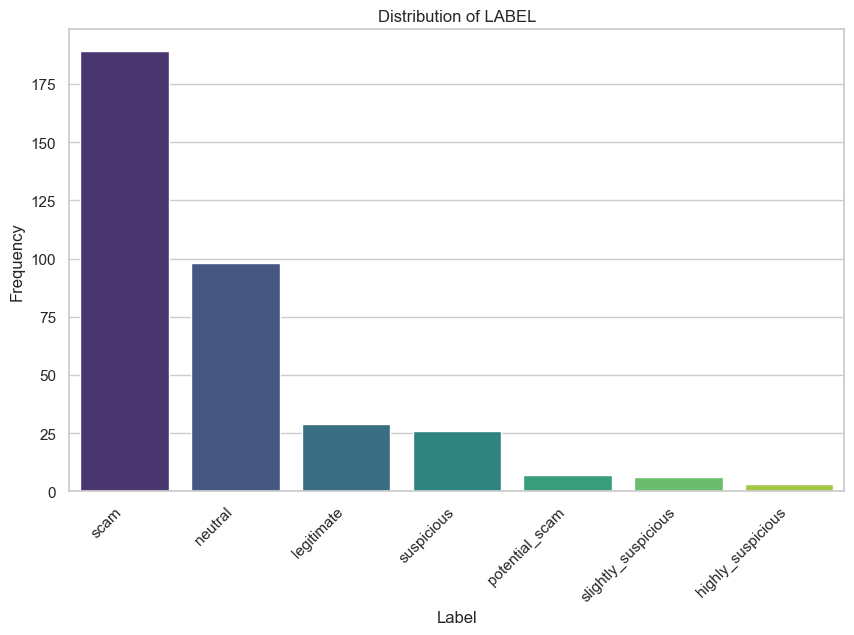

In [52]:
# Set style for plots
sns.set(style="whitegrid")

# Distribution of LABEL
plt.figure(figsize=(10, 6))
label_counts = df['LABEL'].value_counts()
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Distribution of LABEL")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.show()


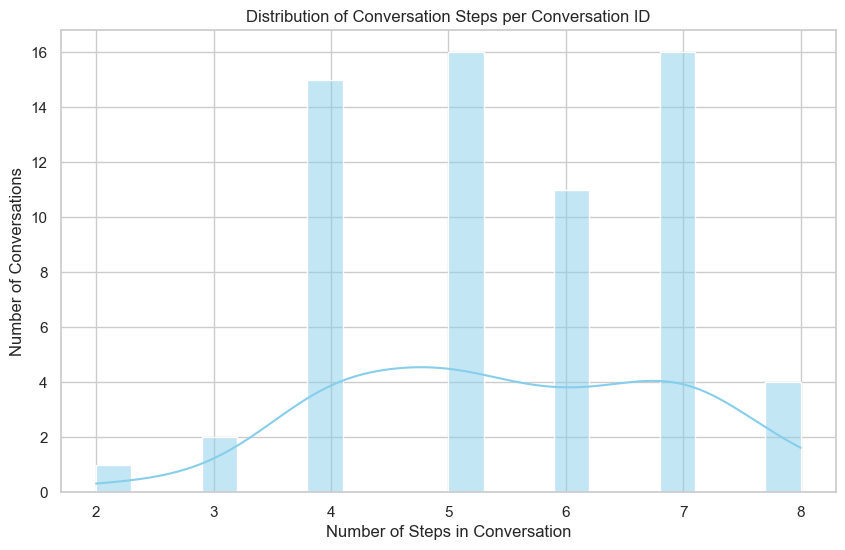

In [53]:
#   Number of Conversation Steps per Conversation ID
plt.figure(figsize=(10, 6))
steps_per_conversation = df['CONVERSATION_ID'].value_counts()
sns.histplot(steps_per_conversation, bins=20, kde=True, color="skyblue")
plt.title("Distribution of Conversation Steps per Conversation ID")
plt.xlabel("Number of Steps in Conversation")
plt.ylabel("Number of Conversations")
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_22844\686236587.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=features_counts.index, y=features_counts.values, palette="magma")


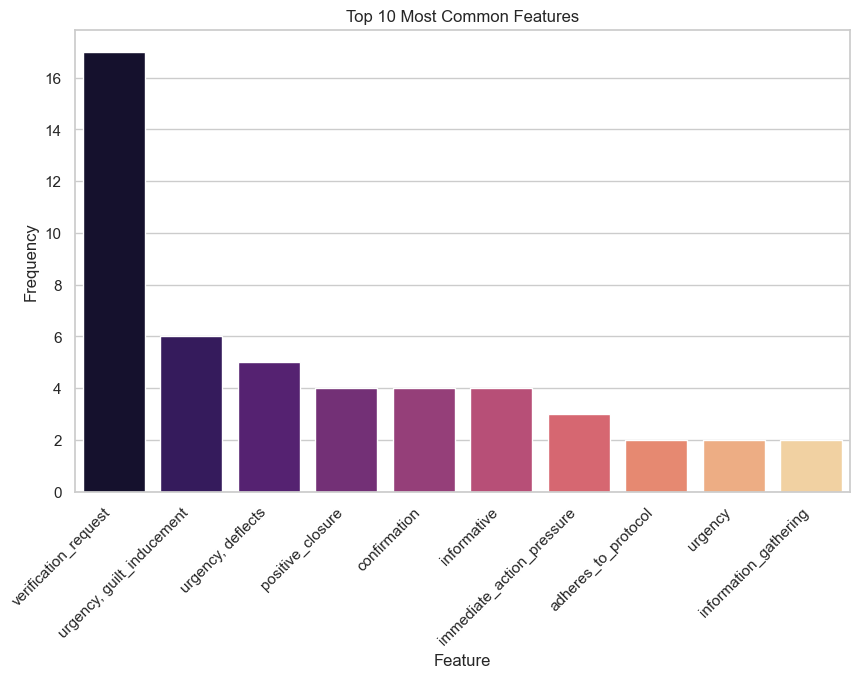

In [10]:
# Top Features in the FEATURES Column
plt.figure(figsize=(10, 6))
features_counts = df['FEATURES'].value_counts().head(10)
sns.barplot(x=features_counts.index, y=features_counts.values, palette="magma")
plt.title("Top 10 Most Common Features")
plt.xlabel("Feature")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.show()

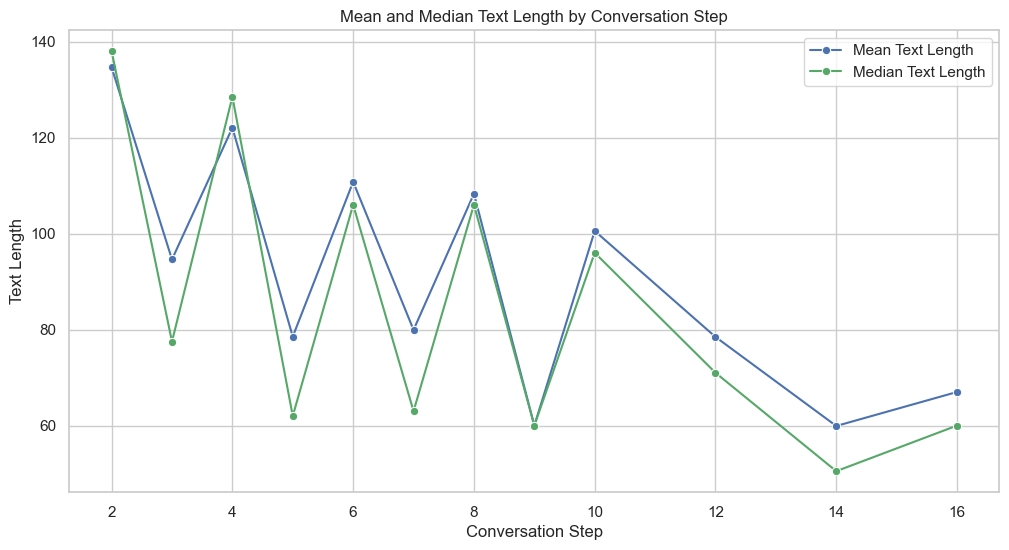

In [11]:
df['TEXT_LENGTH'] = df['TEXT'].apply(len)
text_length_stats = df.groupby('CONVERSATION_STEP')['TEXT_LENGTH'].agg(['mean', 'median']).reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='CONVERSATION_STEP', y='mean', data=text_length_stats, label='Mean Text Length', marker='o', color='b')
sns.lineplot(x='CONVERSATION_STEP', y='median', data=text_length_stats, label='Median Text Length', marker='o', color='g')
plt.title('Mean and Median Text Length by Conversation Step')
plt.xlabel('Conversation Step')
plt.ylabel('Text Length')
plt.legend()


In [12]:
print(df.columns)

# Create the TEXT_LENGTH column if it doesn't exist
if 'TEXT_LENGTH' not in df.columns:
    df['TEXT_LENGTH'] = df['TEXT'].apply(len)

# Calculate correlation between conversation step and text length
correlation = df['CONVERSATION_STEP'].corr(df['TEXT_LENGTH'])
print("Correlation between Conversation Step and Text Length:", correlation)


Index(['CONVERSATION_ID', 'CONVERSATION_STEP', 'TEXT', 'CONTEXT', 'LABEL',
       'FEATURES', 'ANNOTATIONS', 'CONTEXT_LABEL', 'TEXT_LENGTH'],
      dtype='object')
Correlation between Conversation Step and Text Length: -0.2696148929266174


In [13]:
df['TEXT_LENGTH'] = df['TEXT'].apply(len)

# Calculate correlation between conversation step and text length
correlation = df['CONVERSATION_STEP'].corr(df['TEXT_LENGTH'])
print("Correlation between Conversation Step and Text Length:", correlation)

Correlation between Conversation Step and Text Length: -0.2696148929266174


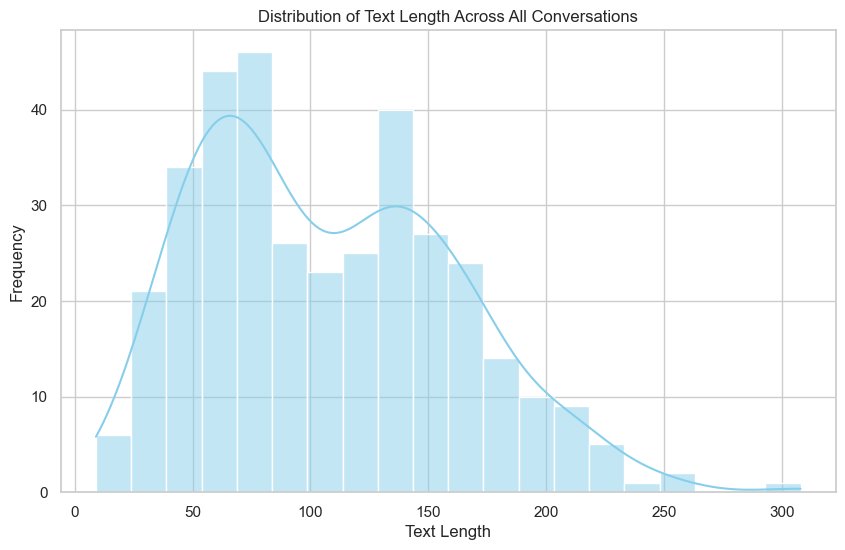

In [14]:
# Additional visualization for Text Length Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['TEXT_LENGTH'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Text Length Across All Conversations")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()